In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
WINDOW_SIZE = 24
FORECAST_PERIOD = 24
BATCH_SIZE = 32
LABEL_NAME = 'T (degC)'

In [3]:
df_train, df_val, df_test = utils.load_data()
print(f"df_train.shape = {df_train.shape}, df_val.shape = {df_val.shape}, df_test.shape = {df_test.shape}")

df_train.shape = (49063, 19), df_val.shape = (14018, 19), df_test.shape = (7010, 19)


In [4]:
num_features = len(df_train.columns)
num_features

19

In [5]:
def build_dataset(df_data, window_size, forecast_period, batch_size, shuffle=True):
    data = np.array(df_data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size + forecast_period,
        sequence_stride=window_size,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    # Note: Use batched_window[:, 1: ...
    ds = ds.map(lambda batched_window: (batched_window[:, :window_size, :], batched_window[:, window_size:, :]))
    return ds

In [6]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE, shuffle=False)

for x_batch, y_batch in train_ds.take(1):
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"y_batch.shape = {y_batch.shape}")

x_batch.shape = (32, 24, 19)
y_batch.shape = (32, 24, 19)


In [7]:
train_ds = build_dataset(df_train, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE)
val_ds = build_dataset(df_val, WINDOW_SIZE, FORECAST_PERIOD, BATCH_SIZE)

In [8]:
model = keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(FORECAST_PERIOD*num_features, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([FORECAST_PERIOD, num_features])
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds, 
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
64/64 [==============================] - 1s 12ms/step - loss: 0.7268 - mean_absolute_error: 0.6587 - val_loss: 0.6402 - val_mean_absolute_error: 0.5939
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 0.4242 - mean_absolute_error: 0.4644 - val_loss: 0.5815 - val_mean_absolute_error: 0.5594
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 0.3250 - mean_absolute_error: 0.3930 - val_loss: 0.5145 - val_mean_absolute_error: 0.5215
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 0.2913 - mean_absolute_error: 0.3663 - val_loss: 0.4694 - val_mean_absolute_error: 0.4988
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 0.2717 - mean_absolute_error: 0.3498 - val_loss: 0.4362 - val_mean_absolute_error: 0.4810
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 0.2573 - mean_absolute_error: 0.3360 - val_loss: 0.4079 - val_mean_absolute_error: 0.4641
Epoch 7/20
64/64 [=========

In [9]:
new_data = df_val.iloc[:WINDOW_SIZE].to_numpy()
new_data = np.expand_dims(new_data, 0)
forecast = model.predict(new_data)
forecast = tf.squeeze(forecast).numpy()
actual = df_val.iloc[WINDOW_SIZE:WINDOW_SIZE + FORECAST_PERIOD].to_numpy()
print(f"forecast.shape = {forecast.shape}, actual.shape = {actual.shape}")

forecast.shape = (24, 19), actual.shape = (24, 19)


In [10]:
ae = np.abs(forecast - actual)
mae = np.mean(ae, axis=0)
mae

array([0.38960314, 0.07996972, 0.10137789, 0.11776336, 0.28714941,
       0.17475224, 0.21608245, 0.26522025, 0.22021628, 0.21968523,
       0.14699699, 0.36379495, 0.51843806, 0.36361087, 0.49693466,
       0.14701613, 0.14607258, 0.23934306, 0.07055798])

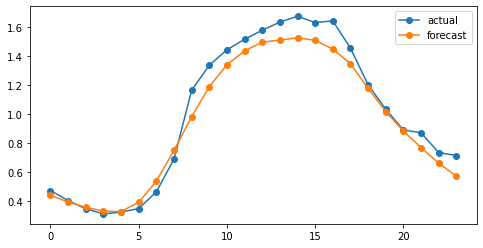

mse = 0.0097, mae = 0.0800


In [11]:
LABEL_NAME = 'T (degC)'
label_idx = list(df_train.columns).index(LABEL_NAME)
utils.plot_result(actual[:, label_idx], forecast[:, label_idx])
utils.evaluate(actual[:, label_idx], forecast[:, label_idx])